# Deflection-Profile Verification
This file verifies the Deflection-Profile implementation provided in the file "deflection_profile.py" of the bmcs_beam package.

In [1]:
%matplotlib inline

In [2]:
from bmcs_cross_section.mkappa import MKappa
from bmcs_beam.beam_config.boundary_conditions import BoundaryConditions
from bmcs_beam.bending.deflection_profile import DeflectionProfile
from bmcs_beam.beam_config.beam_design import BeamDesign
from bmcs_cross_section.cs_design.cs_shape import TShape
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu

In [3]:
def plot(mc):
    fig, ax = plt.subplots(1, 1)
    dp = DeflectionProfile(mc=mc)
    F, w = dp.get_Fw()
    ax.plot(w, F / 1000, c= 'blue', label= 'bmcs_deflection'); ax.legend()
    ax.set_xlabel(r'$w$ [mm]')
    ax.set_ylabel(r'$F$ [kN]')
    plt.show()
    
def plot_fw_ver(mc, ver_data, data, L, mode, f_coef):
    
    # mode: 'multi' to plot multiple experiments and 'one' to plot one experiment
    # f_coef: a coeficient for the 'F' values of the experiment based on the experiment configuration;
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
    dp.mc.plot_mk(ax1)
    dp.plot_fw(ax2)
    if mode == 'multi':
        for i in range(0,data.shape[1],2):
            ax2.plot(data.iloc[:, i+1],data.iloc[:, i] * f_coef, label = data.columns.tolist()[i][0:-2] , alpha=0.25)
        ax2.plot([L/250 , L/250], [0, max(data.iloc[:, 2]) * f_coef],  c='black', ls= '--' ); plt.annotate('L/500', xy=(L/500, max(data.iloc[:, 2]) * f_coef))
        ax2.plot([L/500 , L/500], [0, max(data.iloc[:, 2]) * f_coef],  c='black', ls= ':' ); plt.annotate('L/250', xy=(L/250, max(data.iloc[:, 2]) * f_coef))
    
    else:
        w = ver_data[0]
        f = ver_data[1]
        ax2.plot(w, f * f_coef, c= 'red', label= 'Experiment')
        ax2.plot([L/250 , L/250], [0, max(f) * f_coef],  c='black', ls= '--' ); plt.annotate('L/500', xy=(L/500, max(f) * f_coef))
        ax2.plot([L/500 , L/500], [0, max(f) * f_coef],  c='black', ls= ':' ); plt.annotate('L/250', xy=(L/250, max(f) * f_coef))
    ax2.legend()
    plt.show()

## 1. Checking the model with its default parameters

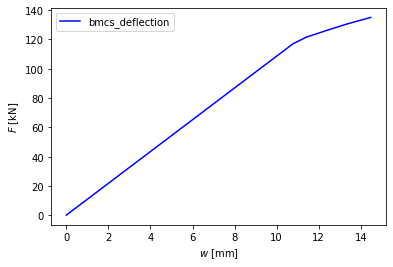

In [4]:
mc = MKappa(low_kappa=-0.000014, high_kappa=0.00001)
plot(mc)

## 2. Verification with experimental results

Verification with experimental results from multiple papers using the summarized parameters in Table 3 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)

Notation in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) | Notation in this file
----------- | -----------
$E$      | E_ct
$E_c$   | E_cc
$E_s$ | E_j
$\varepsilon_{cr}$ | eps_cr
$\varepsilon_{cu}$ | eps_cu
$\varepsilon_{tu}$ | eps_tu
$\varepsilon_{cy}$ | eps_cy
$\mu$ | mu
$\gamma$  | E_cc/E_ct
$\omega$  | eps_cy/eps_cr
$\lambda_{cu}$  | eps_cu/eps_cr
$\beta_{tu}$  | eps_tu/eps_cr
$\psi$  | eps_sy_j/eps_cr
$n$  | E_j/E_ct
$\alpha$  | z_j/h
$r$  | A_s_c/A_s_t
$\rho_g$ | A_j[0]/A_c, where A_j[0] must be tension steel area

### Verification with Rectangluar cross sections
In the following verifications, the parameters will be taken from the parameters summary in Table 3 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)
And the following functions is provided to map the params in the format used in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) to the format of the Deflection model

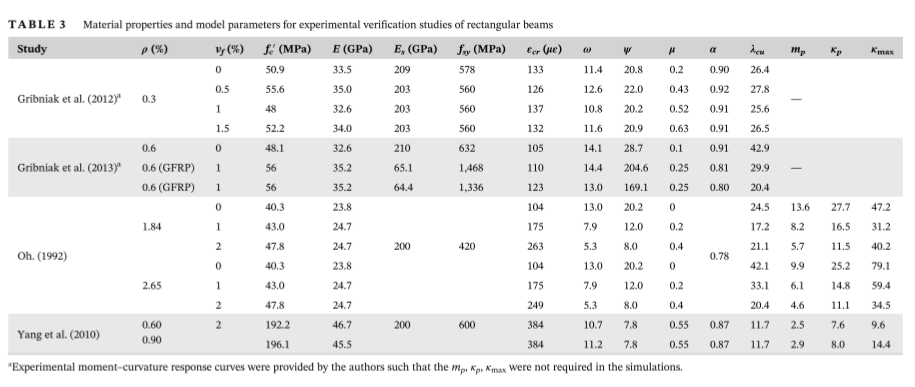

In [5]:
def map_and_assign_params_for_rectangular_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    mc.cross_section_shape.B=b
    mc.cross_section_shape.H=h
    mc.E_cc=E
    mc.E_ct=E # SUPPOSED equal to E_cc!!
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.eps_sy_j=[f_sy / E_s] # or eps_sy_j=psi * eps_cr,
    mc.E_j=[E_s]
    mc.z_j=[h * (1 - alpha)]
    mc.A_j=[rho * b * h]

#### 1. Verification with Heid et al. (2020), [link](https://www.heringinternational.com/fileadmin/media/archive1/downloads/architekturbeton/Bauingenieur_06_2020_S.210-219.pdf), Carbon reinforcement
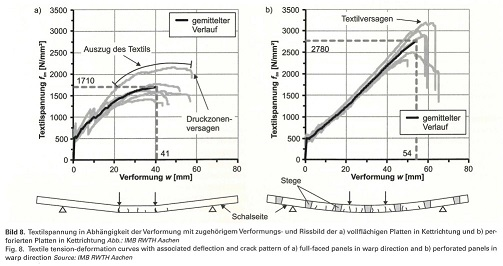

HB-SU-0:
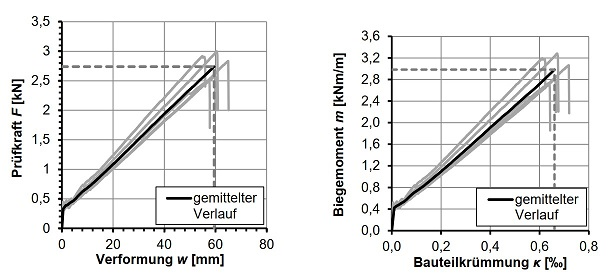

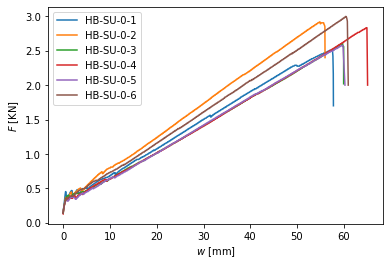

In [6]:
#HB-SU-0
%matplotlib inline
excel_file = join('./verification_data/hei20','hei20.xlsx')
data = pd.read_excel(excel_file, 'HB-SU-0')

for i in range(0,data.shape[1],2):
    plt.plot(data.iloc[:, i+1],data.iloc[:, i], label = data.columns.tolist()[i][0:-2])
w_1= data['HB-SU-0-1_w']  ; f_1= data['HB-SU-0-1_F'] ; ver_data1 = [w_1, f_1/4]; #plt.plot(w_1,f_1, label = 'HB-SU-0-1')
w_2= data['HB-SU-0-2_w']  ; f_2= data['HB-SU-0-2_F'] ; ver_data2 = [w_2, f_2/4]; #plt.plot(w_2,f_2, label = 'HB-SU-0-2')
w_3= data['HB-SU-0-3_w']  ; f_3= data['HB-SU-0-3_F'] ; ver_data3 = [w_3, f_3/4]; #plt.plot(w_3,f_3, label = 'HB-SU-0-3')
w_4= data['HB-SU-0-4_w']  ; f_4= data['HB-SU-0-4_F'] ; ver_data4 = [w_4, f_4/4]; #plt.plot(w_4,f_4, label = 'HB-SU-0-4')
w_5= data['HB-SU-0-5_w']  ; f_5= data['HB-SU-0-5_F'] ; ver_data5 = [w_5, f_5/4]; #plt.plot(w_5,f_5, label = 'HB-SU-0-5')
w_6= data['HB-SU-0-6_w']  ; f_6= data['HB-SU-0-6_F'] ; ver_data6 = [w_6, f_6/4]; #plt.plot(w_6,f_6, label = 'HB-SU-0-6')
plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');


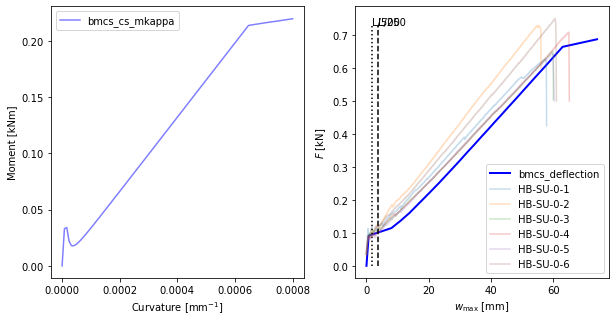

In [7]:
# HB-SU-0

%matplotlib inline
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0008

# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[1]

dp.beam_design.L = 3 * 320
map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2,  #  eps_tu/eps_cr
            b = 45,
            h = 30,
            rho = 7.24/30/150/2,
            v_f = 1.0,
            E = 39500,
            E_s = 240000, 
            f_sy = 2712 , 
            eps_cr = 0.000163, 
            omega = .68, #eps_cy/eps_cr
            psi = 0.0113/0.00016, #eps_sy_j/eps_cr
            mu = .2, #σp/σcr
            alpha = 0.75, #z_j/h
            lambda_cu = 0.11/0.00016) #eps_cu/eps_cr

dp.mc.A_j = np.array([3.62, 3.62])  # A_j[0] for tension steel / A_j[1] for compression steel
dp.mc.z_j = np.array([8, 22])
dp.mc.E_j = np.array([240000, 240000])
dp.mc.eps_sy_j = np.array([0.0113, 0.0113])

plot_fw_ver(dp.mc, ver_data1 ,data, dp.beam_design.L, mode = 'multi', f_coef = .25)

# import bmcs_utils.api as bu
# bu.InteractiveWindow([dp, 
#                       dp.beam_design, 
#                       dp.mc, 
#                       dp.mc.cs_design.cross_section_shape, 
#                       dp.mc.cs_design.cross_section_layout], tight_layout=True).interact()

HB-SU-90:
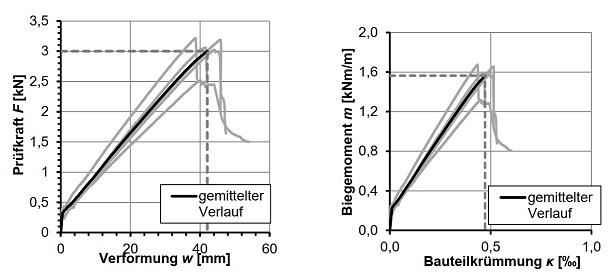

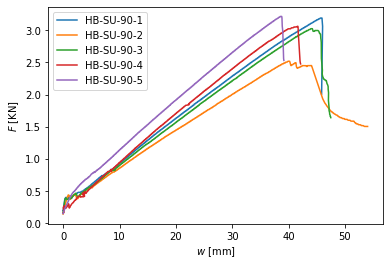

In [8]:
#HB-SU-90
%matplotlib inline
excel_file = join('./verification_data/hei20','hei20.xlsx')
data = pd.read_excel(excel_file, 'HB-SU-90')

for i in range(0,data.shape[1],2):
    plt.plot(data.iloc[:, i+1],data.iloc[:, i], label = data.columns.tolist()[i][0:-2])
w_1= data['HB-SU-90-1_w']  ; f_1= data['HB-SU-90-1_F'] ; ver_data1 = [w_1, f_1/4]; #plt.plot(w_1,f_1, label = 'HB-SU-0-1')
w_2= data['HB-SU-90-2_w']  ; f_2= data['HB-SU-90-2_F'] ; ver_data2 = [w_2, f_2/4]; #plt.plot(w_2,f_2, label = 'HB-SU-0-2')
w_3= data['HB-SU-90-3_w']  ; f_3= data['HB-SU-90-3_F'] ; ver_data3 = [w_3, f_3/4]; #plt.plot(w_3,f_3, label = 'HB-SU-0-3')
w_4= data['HB-SU-90-4_w']  ; f_4= data['HB-SU-90-4_F'] ; ver_data4 = [w_4, f_4/4]; #plt.plot(w_4,f_4, label = 'HB-SU-0-4')
w_5= data['HB-SU-90-5_w']  ; f_5= data['HB-SU-90-5_F'] ; ver_data5 = [w_5, f_5/4]; #plt.plot(w_5,f_5, label = 'HB-SU-0-5')
plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');


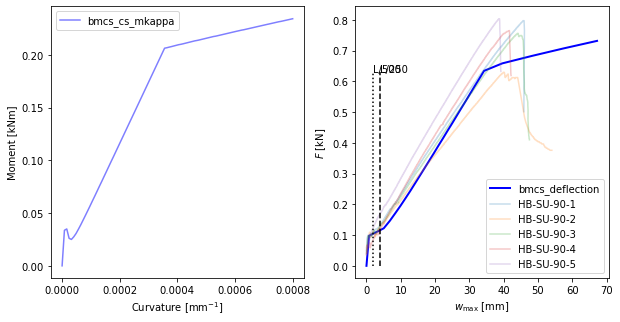

In [9]:
# HB-SU-90

%matplotlib inline
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0008


# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[1]

dp.beam_design.L = 3 * 320
map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2,  #  eps_tu/eps_cr
            b = 45,
            h = 30,
            rho = 14.46/30/317/2,
            v_f = 0.0,
            E = 39500,
            E_s = 240000, 
            f_sy = 1385 , 
            eps_cr = 0.00016,
            omega = .68, #eps_cy/eps_cr
            psi = 0.0057/0.00016, #eps_sy_j/eps_cr
            mu = .2, #σp/σcr
            alpha = 0.75, #z_j/h
            lambda_cu = 0.11/0.00016) #eps_cu/eps_cr

dp.mc.A_j = np.array([3.62*2, 3.62*2])  # A_j[0] for tension steel / A_j[1] for compression steel
dp.mc.z_j = np.array([8, 22])
dp.mc.E_j = np.array([240000, 240000])
dp.mc.eps_sy_j = np.array([0.0057, 0.0057])

plot_fw_ver(dp.mc, ver_data1 ,data, dp.beam_design.L, mode = 'multi', f_coef = 1/4)

# import bmcs_utils.api as bu
# bu.InteractiveWindow([dp, 
#                       dp.beam_design, 
#                       dp.mc, 
#                       dp.mc.cs_design.cross_section_shape, 
#                       dp.mc.cs_design.cross_section_layout], tight_layout=True).interact()

#### 2. Verification with Papanicolaou et al. (2010), [link](https://www.jstage.jst.go.jp/article/jact/8/1/8_1_35/_article), Carbon reinforcement
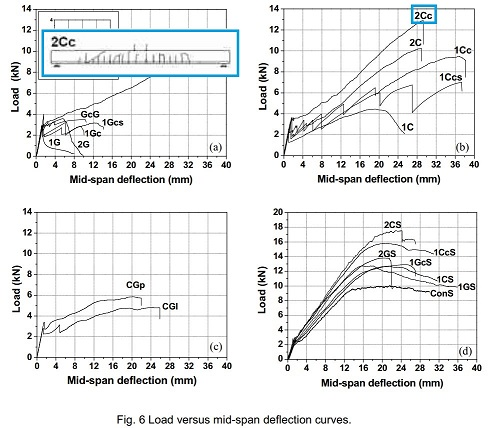

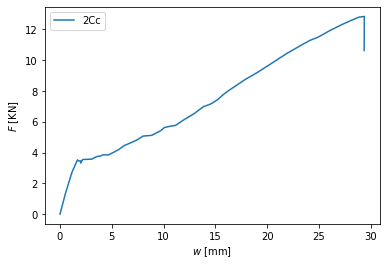

In [24]:
#2Cc
%matplotlib inline
excel_file = join('./verification_data/pap10','pap10.xlsx')
data = pd.read_excel(excel_file, '2Cc')

for i in range(0,data.shape[1],2):
    plt.plot(data.iloc[:, i+1],data.iloc[:, i], label = data.columns.tolist()[i][0:-2])
w_1= data['2Cc_w']  ; f_1= data['2Cc_F'] ; ver_data1 = [w_1, f_1]; #plt.plot(w_1,f_1, label = '2Cc')
plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');


In [103]:
# 2Cc

%matplotlib widget
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.00015

# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[0]

dp.beam_design.L = 1500
map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2,  #  eps_tu/eps_cr
            b = 150,
            h = 88,
            rho = (0.0079 * 2 * 150 * 12) / (150 * 88),
            v_f = 0.0,
            E = 31000,
            E_s = 225000, 
            f_sy = 3350 , 
            eps_cr = 0.0002, # how to calculate it?! 
            omega = .68, #eps_cy/eps_cr
            psi = 0.0148/0.0002, #eps_sy_j/eps_cr
            mu = .2, #σp/σcr
            alpha = 1, #z_j/h
            lambda_cu = 21.93) #eps_cu/eps_cr

# dp.mc.A_j = np.array([3.62, 3.62])  # A_j[0] for tension steel / A_j[1] for compression steel
# dp.mc.z_j = np.array([8, 22])
# dp.mc.E_j = np.array([240000, 240000])
# dp.mc.eps_sy_j = np.array([0.0135, 0.0135])

plot_fw_ver(dp.mc, ver_data1 ,data, dp.beam_design.L, mode = 'one', f_coef = 1)

# import bmcs_utils.api as bu
# bu.InteractiveWindow([dp, 
#                       dp.beam_design, 
#                       dp.mc, 
#                       dp.mc.cs_design.cross_section_shape, 
#                       dp.mc.cs_design.cross_section_layout], tight_layout=True).interact()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### 3. Verification with Bielak (2019), https://doi.org/10.3390/app9071382, Carbon reinforcement
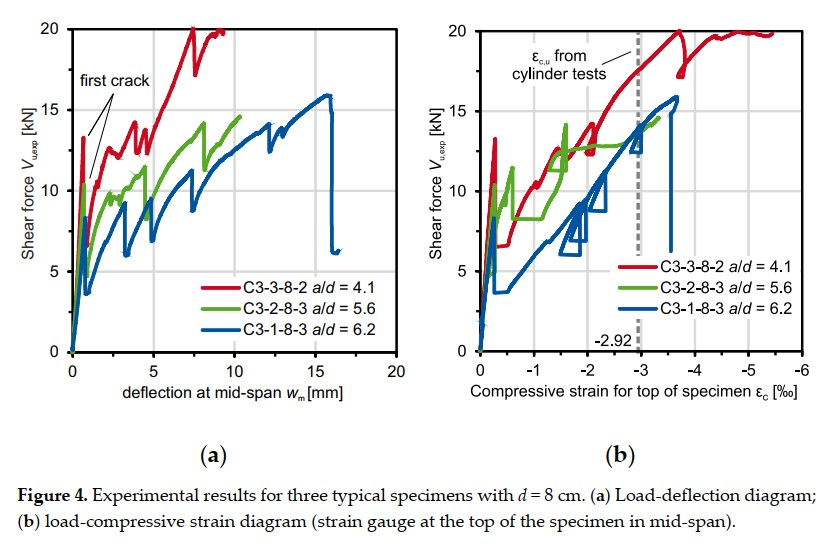

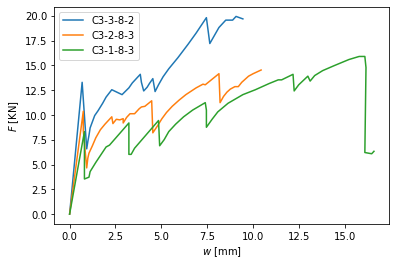

In [12]:
%matplotlib inline
excel_file = join('./verification_data/bie19','bie19.xlsx')
data = pd.read_excel(excel_file)
for i in range(0,data.shape[1],2):
    plt.plot(data.iloc[:, i+1],data.iloc[:, i], label = data.columns.tolist()[i][0:-2]);plt.legend()
w_= data['C3-3-8-2_w']  ; f_= data['C3-3-8-2_F'] ; ver_data = [w_, f_]; #plt.plot(w_,f_, label = 'C3-3-8-2')
w_1= data['C3-2-8-3_w']  ; f_1= data['C3-2-8-3_F'] ; ver_data1 = [w_1, f_1]; #plt.plot(w_1,f_1, label = 'C3-2-8-3')
w_2= data['C3-1-8-3_w']  ; f_2= data['C3-1-8-3_F'] ; ver_data2 = [w_2, f_2]; #plt.plot(w_2,f_2, label = 'C3-1-8-3')

plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');

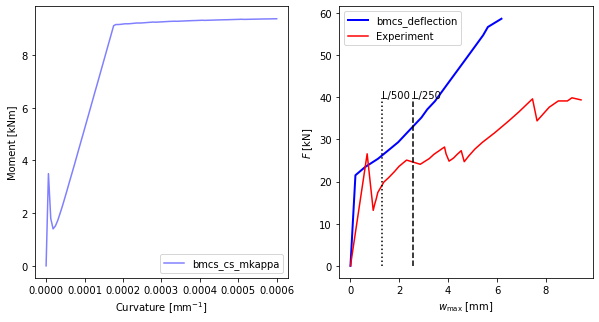

In [13]:
# C3-3-8-2

%matplotlib inline
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0006
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[0]

dp.beam_design.L = 2 * 320

map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2,  #  eps_tu/eps_cr
            b = 200,
            h = 99,
            rho = 0.00234,
            v_f = 0.0,
            E = 44429,
            E_s = 244835, #Warp:244835, Weft:243828
            f_sy = 2737 , #Warp:3221, Weft:3334
            eps_cr = 0.0002616,
            omega = 0.28/0.2616, #eps_cy/eps_cr
            psi = 13.2/0.2616, #eps_sy_j/eps_cr
            mu = 0.2, #σp/σcr
            alpha = 0.77, #z_j/h
            lambda_cu = 2.92/0.2616) #eps_cu/eps_cr

plot_fw_ver(dp.mc, ver_data ,data, dp.beam_design.L, mode = 'one', f_coef =2 )

# import bmcs_utils.api as bu
# bu.InteractiveWindow([dp, 
#                       dp.beam_design, 
#                       dp.mc, 
#                       dp.mc.cs_design.cross_section_shape, 
#                       dp.mc.cs_design.cross_section_layout], tight_layout=True).interact()

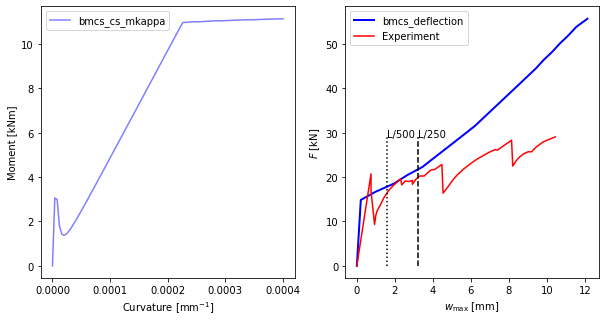

In [14]:
# C3-2-8-3
%matplotlib inline

mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0004


# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[0]

dp.beam_design.L = 2 * 400

map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2,  #  eps_tu/eps_cr
            b = 199,
            h = 100,
            rho = 0.00256,
            v_f = 0.0,
            E = 45346 ,
            E_s = 244835 , #Warp:244835, Weft:243828
            f_sy = 3221 , #Warp:3221, Weft:3334
            eps_cr = 0.0002616,
            omega = 0.28/0.2616, #eps_cy/eps_cr
            psi = 13.2/0.2616, #eps_sy_j/eps_cr
            mu = 0.2, #σp/σcr
            alpha = 0.71, #z_j/h
            lambda_cu = 2.92/0.2616) #eps_cu/eps_cr

plot_fw_ver(dp.mc, ver_data1 ,data, dp.beam_design.L, mode = 'one', f_coef =2)


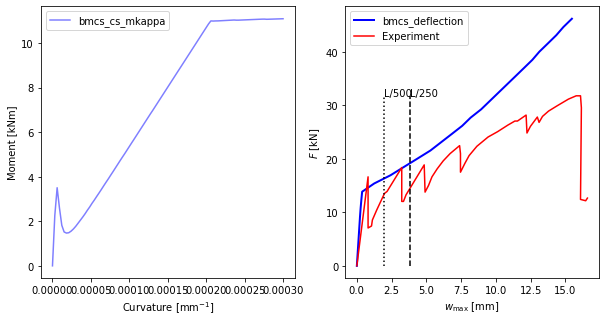

In [15]:
# C3-1-8-3
%matplotlib inline

mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0003
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[0]

dp.beam_design.L = 2 * 480

map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2,  #  eps_tu/eps_cr
            b = 201,
            h = 100,
            rho = 0.00233,
            v_f = 0.0,
            E = 44010 ,
            E_s = 244835 , #Warp:244835, Weft:243828
            f_sy = 3221 , #Warp:3221, Weft:3334
            eps_cr = 0.0002616,
            omega = 0.28/0.2616, #eps_cy/eps_cr
            psi = 13.2/0.2616, #eps_sy_j/eps_cr
            mu = 0.2, #σp/σcr
            alpha = 0.77, #z_j/h
            lambda_cu = 2.92/0.2616) #eps_cu/eps_cr

plot_fw_ver(dp.mc, ver_data2 ,data, dp.beam_design.L, mode = 'one', f_coef =2)


### Verification with T-sections

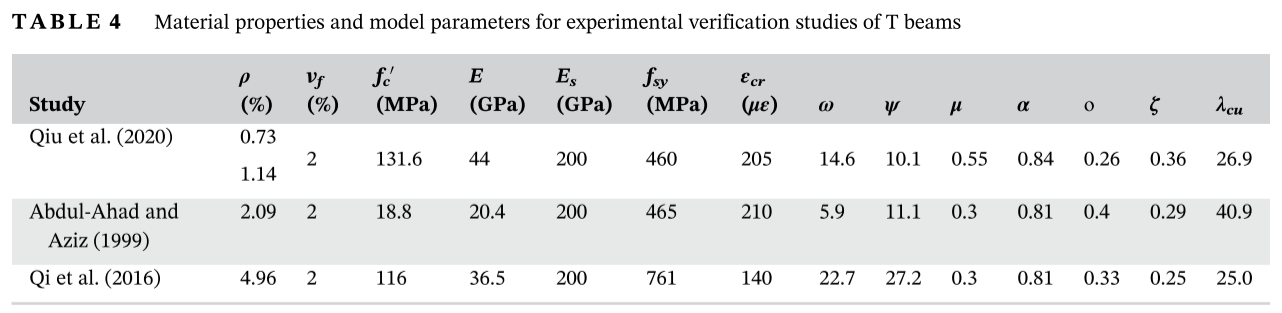

In [16]:
def map_and_assign_params_for_t_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu, o, zeta):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    t_shape = TShape(H= h, B_f = b, B_w = o*b, H_w = (1-zeta)*h)
    mc.cross_section_shape = t_shape
    
    mc.E_cc=E
    mc.E_ct=E # SUPPOSED equal to E_cc!!
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.eps_sy_j=[f_sy / E_s] # or eps_sy_j=psi * eps_cr,
    mc.E_j=[E_s]
    mc.z_j=[h * (1 - alpha)]
    mc.A_j=[rho * b * h]
    

#### 1. Verification with Qi et al. (2016), https://doi.org/10.1002/suco.201500191, Steel reinforcement


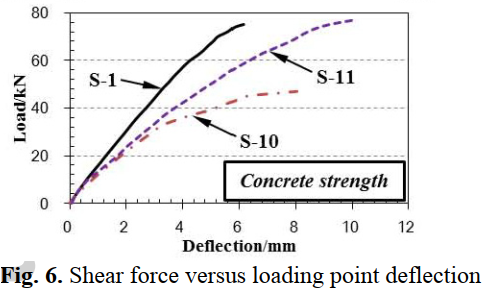

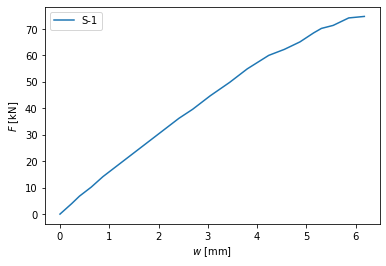

In [17]:
%matplotlib inline

excel_file = join('./verification_data/yao20_yao_mobasher/figure_14','qi16.xlsx') # S_1 line

data = pd.read_excel(excel_file)
w_= data['S_1_exp_w'] ; f_= data['S_1_exp_F'] / 1000; ver_data = [w_, f_]; plt.plot(w_,f_, label = 'S-1')

plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [kN]');

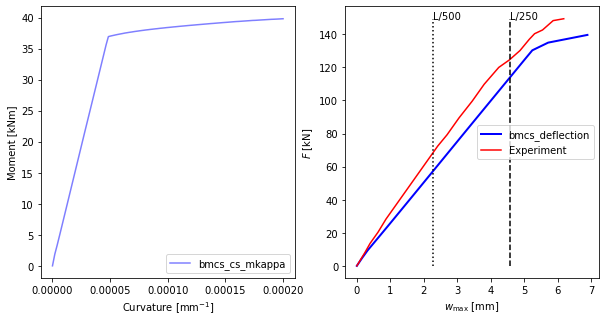

In [18]:
# S-1
%matplotlib inline

mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0002
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[0]

dp.beam_design.L = 1140

map_and_assign_params_for_t_section(dp.mc,
            beta_tu = 15, 
            b = 120,
            h = 140,
            rho = 0.0496,
            v_f = 0.02,
            E = 36500,
            E_s = 200000 ,
            f_sy = 461, # Calibrated
            eps_cr = 0.000140,
            omega = 22.7,
            psi = 27.2,
            mu = 0.3,
            alpha = 0.81,
            o = 0.33, 
            zeta = 0.25,
            lambda_cu = 25)

plot_fw_ver(dp.mc, ver_data ,data, dp.beam_design.L, mode = 'one', f_coef =2 )


#### 2. Verification with Abdul-Ahad and Aziz (1999), https://doi.org/10.1002/suco.201500191, Steel reinforcement
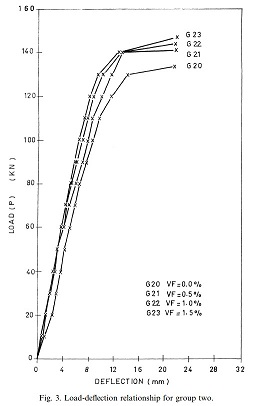

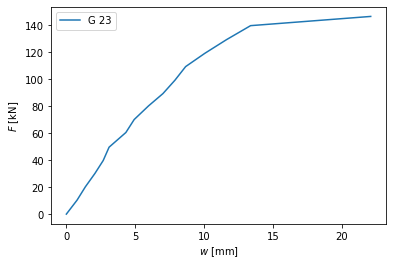

In [19]:
%matplotlib inline
excel_file = join('./verification_data/yao20_yao_mobasher/figure_14', 'abd99.xlsx') # G 23 line
data = pd.read_excel(excel_file)
w_= data['G23_w'] ; f_= data['G23_F'] ; ver_data = [w_, f_]; plt.plot(w_,f_, label = 'G 23')
plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [kN]');

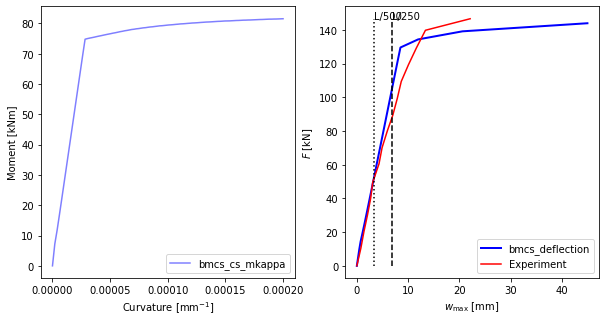

In [20]:
# G 23
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0002
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[1]

dp.beam_design.L = 1700 # Calibrated

map_and_assign_params_for_t_section(dp.mc,
            beta_tu = 15, 
            b = 250,
            h = 210,
            rho = 0.0209,
            v_f = 0.02,
            E = 20400,
            E_s = 200000,
            f_sy = 465,
            eps_cr = 0.000210,
            omega = 5.9,
            psi = 11.1,
            mu = 0.3,
            alpha = 0.81,
            o = 0.4, 
            zeta = 0.29,
            lambda_cu = 40.9)

plot_fw_ver(dp.mc, ver_data ,data, dp.beam_design.L, mode = 'one', f_coef = 1 )